# How to Python Web Scrape the Nasdaq Stock Ex-Dividend Calendar

https://medium.com/c%C3%B3digo-ecuador/how-to-python-web-scrape-the-nasdaq-stock-ex-dividend-calendar-648b6063c659

Web scrape a list of stocks with upcoming ex-dividend dates from the Nasdaq API using the Python pandas, requests, datetime, and calendar modules.

## Install & import required Python packages

You will need the pandas, requests, datetime, and calendar modules to web scrape a list of stocks with upcoming ex-dividend dates from the Nasdaq API using the Python coding language. 


In [15]:
import pandas, requests, calendar
import datetime as dt
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
import yfinance as yf
from tqdm import tqdm # progress

style.use('ggplot')
mpl.rcParams['figure.figsize'] = (16.0, 9.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

class dividend_calendar:
    #class attributes 
    calendars = [] 
    url = 'https://api.nasdaq.com/api/calendar/dividends'
    hdrs =  {'Accept': 'application/json, text/plain, */*',
                 'DNT': "1",
                 'Origin': 'https://www.nasdaq.com/',
                 'Sec-Fetch-Mode': 'cors',
                 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0)'}
    def __init__(self, year, month):
        '''
        Parameters
        ----------
        year : year int
        month : month int

        Returns
        -------
        Sets instance attributes for year and month of object.

        '''
        #instance attributes
        self.year = int(year)
        self.month = int(month)

    def date_str(self, day):
        date_obj = dt.date(self.year, self.month, day)
        date_str = date_obj.strftime(format='%Y-%m-%d')     
        return date_str
    
    def scraper(self, date_str):
        ''' 
        Scrapes JSON object from page using requests module.
          
        Parameters
        - - - - - 
        url : URL string
        hdrs : Header information
        date_str: string in yyyy-mm-dd format
             
        Returns
        - - - -
        dictionary : Returns a JSON dictionary at a given URL.
         
        '''
        params = {'date': date_str}
        page=requests.get(self.url,headers=self.hdrs,params=params)
        dictionary = page.json()
        return dictionary
    
    def dict_to_df(self, dicti):
        ''' 
        Converts the JSON dictionary into a pandas dataframe
        Appends the dataframe to calendars class attribute         
        
        Parameters
        ----------
        dicti : Output from the scraper method as input.
        
        Returns
        -------
        calendar : Dataframe of stocks with that exdividend date
        
        Appends the dataframe to calendars class attribute
        
        If the date is formatted correctly, it will append a 
        dataframe to the calendars list (class attribute).  
        Otherwise, it will return an empty dataframe.         
        '''
         
        rows = dicti.get('data').get('calendar').get('rows')
        calendar = pandas.DataFrame(rows)
        self.calendars.append(calendar)
        return calendar
   
            
    def calendar(self, day):
        '''
        Combines the scrape and dict_to_df methods
        
        Parameters
        ----------
        day : day of the month as string or number.
        
        Returns
        -------
        dictionary : Returns a JSON dictionary with keys 
        dictionary.keys() => data, message, status
        
        Next Levels: 
        dictionary['data'].keys() => calendar, timeframe
        dictionary['data']['calendar'].keys() => headers, rows
        dictionary['data']['calendar']['headers'] => column names
        dictionary['data']['calendar']['rows'] => dictionary list
    
        '''
        day = int(day)
        date_str = self.date_str(day)      
        dictionary = self.scraper(date_str)
        self.dict_to_df(dictionary)          
        return dictionary
           
if __name__ == '__main__':
    year = 2020
    month = 6

    day_today = int(dt.datetime.now().strftime("%d"))
    
#get number of days in month
    days_in_month = calendar.monthrange(year, month)[1]
#create calendar object    
    february = dividend_calendar(year, month)
#define lambda function to iterate over list of days     
    function = lambda days: february.calendar(days)
    
#define list of ints between 1 and the number of days in the month
    iterator = list(range(1, days_in_month+1))
#     iterator = list(range(day_today+1, days_in_month+1))
#Scrape calendar for each day of the month                    
    objects = list(map(function, iterator))
#concatenate all the calendars in the class attribute
    concat_df = pandas.concat(february.calendars)
    
#Drop any rows with missing data
    drop_df = concat_df.dropna(how='any')
    
#set the dataframe's row index to the company name
    final_df = drop_df.set_index('companyName')

# print(final_df.info())
# print(final_df.tail())

In [16]:
# print(yf.Ticker("AAPL").info)
# print(yf.Ticker("AAPL").recommendations)
# print(yf.Ticker("ACN").history(start=dt.datetime(2010, 1, 1), end=dt.datetime.now()))
print(yf.Ticker("ACN").history("max"))

              Open    High     Low   Close    Volume  Dividends  Stock Splits
Date                                                                         
2001-07-19   11.30   11.44   11.23   11.35  34994300        0.0           0.0
2001-07-20   11.26   11.26   11.08   11.23   9238500        0.0           0.0
2001-07-23   11.23   11.23   10.89   11.23   7501000        0.0           0.0
2001-07-24   11.19   11.20   11.00   11.12   3537300        0.0           0.0
2001-07-25   11.00   11.19   10.96   11.19   4208100        0.0           0.0
...            ...     ...     ...     ...       ...        ...           ...
2020-06-02  204.09  205.79  202.34  205.78   1939200        0.0           0.0
2020-06-03  204.42  207.83  204.31  207.28   1605400        0.0           0.0
2020-06-04  206.09  207.79  202.33  203.10   2451400        0.0           0.0
2020-06-05  205.99  209.72  204.79  208.49   2537900        0.0           0.0
2020-06-08  207.51  211.32  207.00  211.28   1515809        0.0 

In [17]:
today_price = []

for symbol in tqdm(list(final_df['symbol'])):
    symbol = symbol.replace('.', '-')
    company = yf.Ticker(symbol)
    df2 = company.history(period="7d")
    df2.dropna(inplace=True)
    today_price.append(df2.iloc[-1, df2.columns.get_loc('Close')])

today_time = dt.datetime.now()
final_df[today_time] = today_price
div_perc= final_df['dividend_Rate'] / final_df[today_time] * 100.0
final_df.insert(2, 'Dividend Percent', div_perc)

100%|████████████████████████████████████████████████████████████████████████████████| 847/847 [03:37<00:00,  3.90it/s]


                                                   symbol dividend_Ex_Date  \
companyName                                                                  
Avangrid, Inc.                                        AGR       06/01/2020   
Cathay General Bancorp                               CATY       06/01/2020   
China Petroleum & Chemical Corporation                SNP       06/01/2020   
First Trust Senior Floating Rate Income Fund II       FCT       06/01/2020   
First Trust/Aberdeen Global Opportunity Income ...    FAM       06/01/2020   
...                                                   ...              ...   
VEREIT Inc.                                           VER       06/29/2020   
Xerox Holdings Corporation                            XRX       06/29/2020   
Cardinal Health, Inc.                                 CAH       06/30/2020   
CubeSmart                                            CUBE       06/30/2020   
Jernigan Capital, Inc.                               JCAP       

(0.0, 5.0)

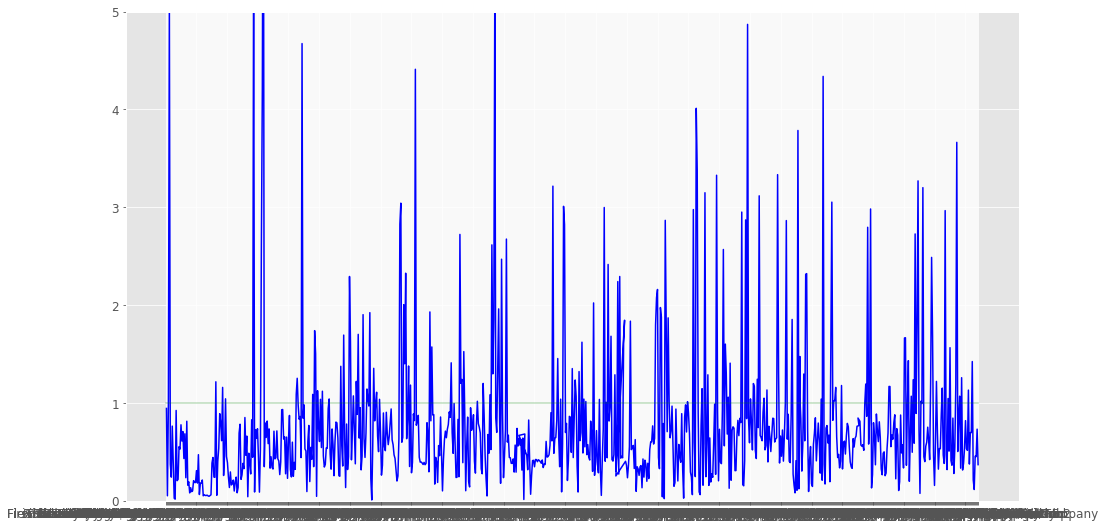

In [21]:
# Output all stocks that dividend > threshold
threshold = 0.8
print(final_df[final_df['Dividend Percent'] >= threshold])
# final_df[final_df['Dividend_Perc'] >= threshold].to_csv('stock_dividend.csv')
final_df[final_df['Dividend Percent'] >= threshold].to_csv('stock_dividend_{}.csv'.format(day_today))


plt.plot(final_df['Dividend Percent'], color='blue')
plt.plot(final_df.index, [1]*len(final_df.index), color='green', alpha=0.25)
plt.ylim([0, 5])

In [5]:
start = dt.datetime(year, month, 1)
end = dt.datetime.now()
start = end - dt.timedelta(days=7)
today_price = []

for symbol in list(final_df['symbol']):
    symbol = symbol.replace('.', '-')
    df2 = web.DataReader(symbol, 'yahoo', start, end)
    df2.reset_index(inplace=True)
    df2.set_index("Date", inplace=True)
    today_price.append(df2.iloc[-1, df2.columns.get_loc('Adj Close')])
    
# print(len(final_df.index), len(today_price))
# print(today_price)
final_df['Today_Price'] = today_price
    
print(final_df.tail())

                              symbol dividend_Ex_Date payment_Date  \
companyName                                                          
Quanta Services, Inc.            PWR       06/30/2020   07/15/2020   
Raymond James Financial, Inc.    RJF       06/30/2020   07/15/2020   
Republic Services, Inc.          RSG       06/30/2020   07/15/2020   
State Street Corporation         STT       06/30/2020   07/16/2020   
Wolverine World Wide, Inc.       WWW       06/30/2020   08/03/2020   

                              record_Date  dividend_Rate  \
companyName                                                
Quanta Services, Inc.          07/01/2020          0.050   
Raymond James Financial, Inc.  07/01/2020          0.370   
Republic Services, Inc.        07/01/2020          0.405   
State Street Corporation       07/01/2020          0.520   
Wolverine World Wide, Inc.     07/01/2020          0.100   

                               indicated_Annual_Dividend announcement_Date  \
companyNam

In [22]:
plt.plot(final_df['dividend_Rate'] / final_df['Today_Price'] )

KeyError: 'Today_Price'